<a href="https://colab.research.google.com/github/kapilsuara/Loan-Defaulter/blob/main/Loan_Defaulter_ML_Predication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

In [70]:
df = pd.read_csv("/content/Loan_default.csv") # load data set

In [71]:
df  = df.drop(["LoanID"],axis=1) # there is no use of LoanId


In [72]:
df.head()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


#Feature Engineering

###Ordinal Encoding



In [73]:
# List of categorical columns to analyze
categorical_columns = [
    'Education', 'EmploymentType', 'MaritalStatus',
    'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner'
]

# Iterate through each column and calculate the counts, percentages, and averages
for col in categorical_columns:
    print(f"\nAnalysis for {col}:\n")

    # Group by the column and 'Default', then count occurrences
    counts = df.groupby([col, 'Default']).size().unstack(fill_value=0)

    # Calculate total counts for each category
    total_counts = counts.sum(axis=1)

    # Calculate percentages of defaults and non-defaults
    percentages = (counts.div(total_counts, axis=0) * 100).round(2)

    # Add an average column for 'Default' weighted by the counts
    averages = df.groupby(col)['Default'].mean().round(2)

    # Combine counts, percentages, and averages into one table
    summary = counts.copy()
    summary['Total'] = total_counts
    summary['Default %'] = percentages[1] if 1 in percentages.columns else 0
    summary['Non-Default %'] = percentages[0] if 0 in percentages.columns else 0
    # summary['Default Rate (Average)'] = averages

    # Print the summary
    print(summary)



Analysis for Education:

Default          0     1  Total  Default %  Non-Default %
Education                                                
Bachelor's   56577  7789  64366      12.10          87.90
High School  55673  8230  63903      12.88          87.12
Master's     56633  6908  63541      10.87          89.13
PhD          56811  6726  63537      10.59          89.41

Analysis for EmploymentType:

Default             0     1  Total  Default %  Non-Default %
EmploymentType                                              
Full-time       57632  6024  63656       9.46          90.54
Part-time       56484  7677  64161      11.97          88.03
Self-employed   56404  7302  63706      11.46          88.54
Unemployed      55174  8650  63824      13.55          86.45

Analysis for MaritalStatus:

Default            0      1  Total  Default %  Non-Default %
MaritalStatus                                               
Divorced       74376  10657  85033      12.53          87.47
Married        7

Why Ordinal Encoding instead of One hot encoding


---

Based on statistical analysis, the categories in certain variables exhibit a clear order in their relationship with the target variable (Default). For example, in the "Education" variable, the default rate decreases as the education level increases (High School: 12.88%, Bachelor's: 12.10%, Master's: 10.87%, PhD: 10.59%). This trend is statistically significant, demonstrating an inherent order among the categories. By applying Ordinal Encoding, we can capture this order and utilize the progression between categories effectively, which enhances the model's ability to predict loan defaults.

In [74]:


# List of categorical columns to analyze
categorical_columns = [
    'Education', 'EmploymentType', 'MaritalStatus',
    'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner'
]

# Initialize an OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Dynamically generate ordinal mappings
ordinal_mappings = {}

for col in categorical_columns:
    # Group by the column and calculate the mean default rate
    default_rates = df.groupby(col)['Default'].mean().sort_values()

    # Generate the ordinal mapping dynamically based on default rates
    mapping = {category: rank for rank, category in enumerate(default_rates.index, start=1)}
    ordinal_mappings[col] = mapping

    # Apply the mapping to the column in the DataFrame
    df[col] = df[col].map(mapping)

    # print(f"Ordinal mapping for {col}: {mapping}")

# Display the first few rows of the updated DataFrame
df.head()


,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,3,1,3,1,1,2,1,0
1,69,50432,124440,458,15,1,4.81,60,0.68,2,1,1,2,2,2,1,0
2,46,84208,129188,451,26,3,21.17,24,0.31,2,4,3,1,1,4,2,1
3,32,31713,44799,743,0,3,7.07,24,0.23,4,1,1,2,2,5,2,0
4,60,20437,9139,633,8,4,6.51,48,0.73,3,4,3,2,1,4,2,0


###Train Test Split

In [75]:

from sklearn.model_selection import train_test_split

# Assuming 'Default' is your target variable
X = df.drop('Default', axis=1)
y = df['Default']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (204277, 16)
y_train shape: (204277,)
X_test shape: (51070, 16)
y_test shape: (51070,)


###Feature Scaling

In [76]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Now X_train_scaled and X_test_scaled contain the normalized data
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)


X_train_scaled shape: (204277, 16)
X_test_scaled shape: (51070, 16)


In [77]:
def find_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Example usage for a specific column (replace 'LoanAmount' with the column you want to analyze)
numerical_columns = ['LoanAmount', 'LoanTerm', 'CreditScore']
#Check if all numerical_columns are in df
for col in numerical_columns:
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in DataFrame. Skipping...")
        continue  # Skip to the next column
    outliers = find_outliers_iqr(df[col])
    print(f"Outliers in {col}: {outliers}")
    print(f"Number of outliers in {col}: {len(outliers)}")


Outliers in LoanAmount: Series([], Name: LoanAmount, dtype: int64)
Number of outliers in LoanAmount: 0
Outliers in LoanTerm: Series([], Name: LoanTerm, dtype: int64)
Number of outliers in LoanTerm: 0
Outliers in CreditScore: Series([], Name: CreditScore, dtype: int64)
Number of outliers in CreditScore: 0


In [78]:


# from sklearn.decomposition import PCA

# # Initialize PCA with the desired number of components
# pca = PCA(n_components=10)  # Example: Reduce to 2 principal components

# # Fit PCA on the scaled training data
# pca.fit(X_train_scaled)

# # Transform the training and testing data using the fitted PCA
# X_train_scaled = pca.transform(X_train_scaled)
# X_test_scaled = pca.transform(X_test_scaled)

# print("X_train_pca shape:", X_train_scaled.shape)
# print("X_test_pca shape:", X_test_scaled.shape)


In [79]:
X_train_scaled.shape

(204277, 16)

In [80]:
# prompt: do undersampling on x_train_scaled and y_train_scaled

from imblearn.under_sampling import RandomUnderSampler

# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Resample the training data
X_train_scaled_sampling, y_train_scaled = rus.fit_resample(X_train_scaled, y_train)

# Now X_train_scaled_resampled and y_train_scaled_resampled have balanced classes
print("X_train_scaled_resampled shape:", X_train_scaled.shape)
print("y_train_scaled_resampled shape:", y_train_scaled.shape)


X_train_scaled_resampled shape: (204277, 16)
y_train_scaled_resampled shape: (47506,)


**loan default prediction. In such scenarios, the cost of false negatives (predicting a defaulter as non-defaulter) is typically much higher than the cost of false positives (predicting a non-defaulter as defaulter). This is because failing to identify a defaulter (false negative) can lead to significant financial losses, while falsely identifying a non-defaulter (false positive) might only result in a missed opportunity.**

In [81]:

# Apply logistic regression

#before sampling

from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
logreg = LogisticRegression(random_state=42)  # You can adjust hyperparameters as needed

# Train the model using the scaled training data
logreg.fit(X_train_scaled, y_train)

# Make predictions on the scaled test data
y_pred = logreg.predict(X_test_scaled)

# Evaluate the model (example: accuracy)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Logistic Regression: {accuracy}")

# You can further evaluate using other metrics like precision, recall, F1-score, etc.
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


Accuracy of Logistic Regression: 0.8858821225768553
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45170
           1       0.61      0.03      0.06      5900

    accuracy                           0.89     51070
   macro avg       0.75      0.52      0.50     51070
weighted avg       0.86      0.89      0.84     51070



In [82]:

# Apply logistic regression

#after sampling

from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
logreg = LogisticRegression(random_state=42)  # You can adjust hyperparameters as needed

# Train the model using the scaled training data
logreg.fit(X_train_scaled_sampling, y_train_scaled)

# Make predictions on the scaled test data
y_pred = logreg.predict(X_test_scaled)

# Evaluate the model (example: accuracy)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Logistic Regression: {accuracy}")

# You can further evaluate using other metrics like precision, recall, F1-score, etc.
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


Accuracy of Logistic Regression: 0.6765615821421578
              precision    recall  f1-score   support

           0       0.94      0.67      0.79     45170
           1       0.22      0.70      0.33      5900

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.68      0.73     51070



Key Insights:
Model 1 (Without Sampling):

High Accuracy (88.59%): This is misleading because the dataset is imbalanced, and the model is biased towards the majority class (non-defaulters).

Very Low Recall for Class 1 (3%): The model fails to identify 97% of actual defaulters, which is unacceptable for loan default prediction. Missing defaulters can lead to significant financial losses.

High Precision for Class 1 (61%): While the model is good at avoiding false positives (predicting non-defaulters as defaulters), this comes at the cost of missing most actual defaulters.

Model 2 (With Sampling):

Lower Accuracy (67.66%): Accuracy drops because the model is now better at identifying the minority class (defaulters), which is more important in this context.

High Recall for Class 1 (70%): The model identifies 70% of actual defaulters, which is a significant improvement over Model 1. This is critical for minimizing financial risk.

Lower Precision for Class 1 (22%): The model has more false positives (predicting non-defaulters as defaulters), but this is often acceptable in loan default prediction because the cost of missing a defaulter is higher.

Which Model is Better?
Model 2 (With Sampling) is better for loan default prediction.

It has a much higher recall for class 1 (70% vs. 3%), meaning it is better at identifying actual defaulters.

While its precision for class 1 is lower, this trade-off is acceptable in this context because the primary goal is to minimize the risk of financial loss by identifying as many defaulters as possible.

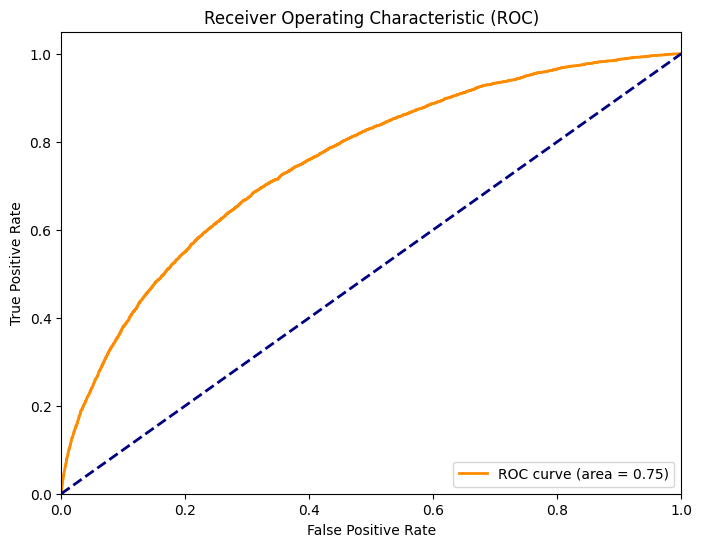

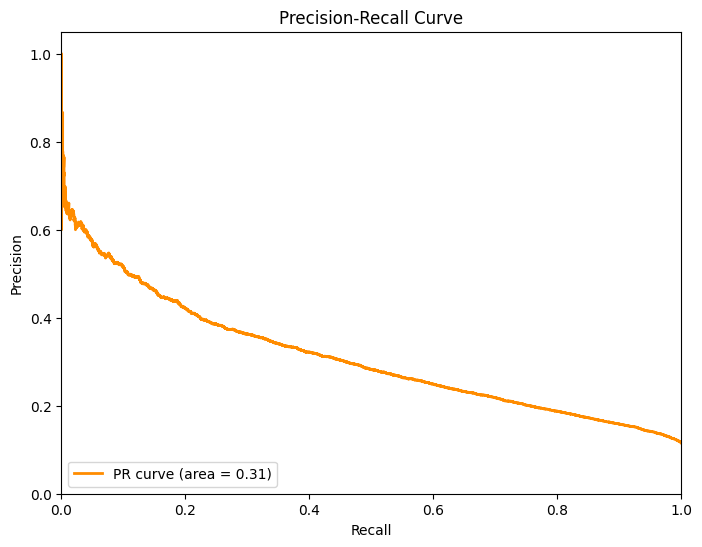

In [83]:


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score



# Predict probabilities instead of class labels
y_pred_prob = logreg.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Calculate precision-recall curve and average precision
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {average_precision:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [84]:
# Feature Importance


# Get feature importances (coefficients for logistic regression)
feature_importances = logreg.coef_[0]

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances in a user-friendly format
for index, row in feature_importance_df.iterrows():
    print(f"{row['Feature']} feature importance: {row['Importance']:.4f}")


InterestRate feature importance: 1.5764
LoanAmount feature importance: 1.0144
EmploymentType feature importance: 0.3946
HasCoSigner feature importance: 0.3003
NumCreditLines feature importance: 0.2902
HasDependents feature importance: 0.2645
Education feature importance: 0.2541
DTIRatio feature importance: 0.2392
MaritalStatus feature importance: 0.2242
LoanPurpose feature importance: 0.1944
HasMortgage feature importance: 0.1746
LoanTerm feature importance: -0.0115
CreditScore feature importance: -0.4518
MonthsEmployed feature importance: -1.1173
Income feature importance: -1.1228
Age feature importance: -2.0178


In [86]:
# Apply Decision Tree Classifier

#with sampling

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)  # You can adjust hyperparameters

# Train the model
dt_classifier.fit(X_train_scaled_sampling, y_train_scaled)

# Make predictions
y_pred_dt = dt_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy of Decision Tree Classifier: {accuracy_dt}")
print(classification_report(y_test, y_pred_dt))


Accuracy of Decision Tree Classifier: 0.5883493244566281
              precision    recall  f1-score   support

           0       0.91      0.59      0.72     45170
           1       0.16      0.58      0.24      5900

    accuracy                           0.59     51070
   macro avg       0.53      0.58      0.48     51070
weighted avg       0.83      0.59      0.66     51070



In [88]:
# apply naive baise

# after sampling

from sklearn.naive_bayes import GaussianNB

# Initialize the Gaussian Naive Bayes model
gnb = GaussianNB()

# Train the model
gnb.fit(X_train_scaled_sampling , y_train_scaled)

# Make predictions
y_pred_gnb = gnb.predict(X_test_scaled)

# Evaluate the model
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print(f"Accuracy of Gaussian Naive Bayes: {accuracy_gnb}")
print(classification_report(y_test, y_pred_gnb))


Accuracy of Gaussian Naive Bayes: 0.6711376542001175
              precision    recall  f1-score   support

           0       0.95      0.67      0.78     45170
           1       0.22      0.71      0.33      5900

    accuracy                           0.67     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.67      0.73     51070



In [87]:
# random forest

# before sampling

from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)  # You can adjust hyperparameters

# Train the model
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of Random Forest Classifier: {accuracy_rf}")
print(classification_report(y_test, y_pred_rf))


Accuracy of Random Forest Classifier: 0.8869199138437439
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45170
           1       0.64      0.05      0.09      5900

    accuracy                           0.89     51070
   macro avg       0.77      0.52      0.51     51070
weighted avg       0.86      0.89      0.84     51070



In [89]:
# random forest

# after sampling

from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)  # You can adjust hyperparameters

# Train the model
rf_classifier.fit(X_train_scaled_sampling, y_train_scaled)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy of Random Forest Classifier: {accuracy_rf}")
print(classification_report(y_test, y_pred_rf))


Accuracy of Random Forest Classifier: 0.686097513217153
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     45170
           1       0.22      0.67      0.33      5900

    accuracy                           0.69     51070
   macro avg       0.58      0.68      0.56     51070
weighted avg       0.86      0.69      0.74     51070



In [90]:
# Feature Importance for Random Forest

import pandas as pd

# Assuming rf_classifier is your trained RandomForestClassifier model
# and X_train is your training features DataFrame

feature_importances = rf_classifier.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances in a user-friendly format
for index, row in feature_importance_df.iterrows():
    print(f"{row['Feature']} feature importance: {row['Importance']:.4f}")


InterestRate feature importance: 0.1320
Age feature importance: 0.1314
Income feature importance: 0.1245
LoanAmount feature importance: 0.1116
MonthsEmployed feature importance: 0.0995
CreditScore feature importance: 0.0927
DTIRatio feature importance: 0.0833
LoanPurpose feature importance: 0.0362
LoanTerm feature importance: 0.0362
Education feature importance: 0.0304
NumCreditLines feature importance: 0.0300
EmploymentType feature importance: 0.0298
MaritalStatus feature importance: 0.0231
HasMortgage feature importance: 0.0141
HasDependents feature importance: 0.0132
HasCoSigner feature importance: 0.0119
